In [135]:
import numpy as np
from datasets import fetch_mnist

###### ######  #   #  #####  ####  ###
   #   ##      ##  #  #      #  #  #  #
   #   ######  # # #  #####  #  #  ###
   #   ##      #  ##      #  #  #  #  #
   #   ######  #   #  #####  ####  #  #
class Tensor (object):
    
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        if(id is None):
            self.id = np.random.randint(0,100000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    raise Exception("OP!")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            assert grad.autograd == False
            
            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    if not isinstance(new, Tensor):
                        new = Tensor(new)
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    if not isinstance(new, Tensor):
                        new = Tensor(new)
                    self.creators[1].backward(new, self)                   
                    
                if(self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
                    
                if(self.creation_op == "sigmoid"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))
                
                if(self.creation_op == "tanh"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))

                if(self.creation_op == "leaky_relu"):
                    grad_input = grad * np.where(self.creators[0].data >= 0, 1, self.creators[1].data)
                    if not isinstance(grad_input, Tensor):
                        grad_input = Tensor(grad_input)
                    self.creators[0].backward(grad_input, self)
                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if(self.autograd):
            return Tensor(1 / (1 + np.exp(-self.data)),
                          autograd=True,
                          creators=[self],
                          creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if(self.autograd):
            return Tensor(np.tanh(self.data),
                          autograd=True,
                          creators=[self],
                          creation_op="tanh")
        return Tensor(np.tanh(self.data))
    
    def leaky_relu(self, alpha):
        if self.autograd:
            alpha_tensor = Tensor(np.array([alpha]))
            result = Tensor(np.where(self.data >= 0, self.data, alpha_tensor.data * self.data),
                            autograd=True,
                            creators=[self],
                            creation_op="leaky_relu")
            result.alpha = alpha_tensor
            return result
        return Tensor(np.where(self.data >= 0, self.data, alpha * self.data))
    
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  

##### ####  #### 
#     #     #   #
##### #  ## #   #
    # #   # #   #
##### ##### # ##


class SGD(object):

    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha

    def zero(self):
        for p in self.parameters:
            p.grad.data *=0
    
    def step(self, zero=True):

        for p in self.parameters:
            p.data -= p.grad.data * self.alpha

            if(zero):
                p.grad.data *= 0



#        #   #   # ####  ###
#        #   #   # #     #  #
#       # #   ###  ####  # #
#      #####   #   #     #  #
####  #     #  #   ####  #   #

class Layer(object):
    def __init__(self):
        self.parameters = list()

    def get_parameters(self):
        return self.parameters

class Linear(Layer):

    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        W = (np.random.randn(n_inputs, n_outputs)*np.sqrt(2.0/n_inputs))
        self.weight =Tensor(W, autograd = True)
        self.bias = Tensor(np.zeros(n_outputs), autograd=True)

        self.parameters.append(self.weight)
        self.parameters.append(self.bias)

    def forward(self, input):
        return input.mm(self.weight)+self.bias.expand(0, len(input.data))


class Sequential(Layer):

    def __init__(self, layers=list()):
        super().__init__()
        self.layers = layers

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def get_parameters(self):
        params = list()
        for l in self.layers:
            params +=l.get_parameters()
        return params

class Tanh(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input.tanh()

class Sigmoid(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input.sigmoid()
    
class LeakyReLU(Layer):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha

    def forward(self, input):
        alpha_tensor = Tensor(np.array([self.alpha]))
        result = Tensor(np.where(input.data >= 0, input.data, alpha_tensor.data * input.data),
                        autograd=True,
                        creators=[input, alpha_tensor],
                        creation_op="leaky_relu")
        result.alpha = alpha_tensor
        return result

class MSELoss(Layer):

    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        return ((pred-target)*(pred-target)).sum(0)
    

In [162]:
x_train, y_train, x_test, y_test = fetch_mnist()

np.random.seed(0)

x_train = x_train.astype("float32") / 255

x_train = x_train.reshape(60000, 28*28)[:1000]
y_train = y_train[:1000]

new = [[0 for i in range(10)] for j in range(len(y_train))]

for x, i in enumerate(y_train):
    new[x][i] = 1

y_train = np.array(new)
x_train = np.array(x_train)

data = Tensor(x_train, autograd = True)
target = Tensor(y_train, autograd = True)


model = Sequential([Linear(28*28,60), LeakyReLU(), Linear(60,20), LeakyReLU(), Linear(20,10), Sigmoid()])


criterion = MSELoss()

optim = SGD(parameters = model.get_parameters(), alpha=0.00005)

for i in range(200):
    pred = model.forward(data)
    loss = criterion.forward(pred, target)
    print("STEP {} \ LOSS {}".format(i, (np.sum(loss.data) /60000)))
    loss.backward(Tensor(np.ones_like(loss.data)))
    optim.step()
    np.set_printoptions(suppress=True)

print("NOW MODEL IS TRAINED")

for z in [1,22,33,55,100,10, 66,67,68,69,70]:
    x= x_train[z]
    x = Tensor(x)
    pp = model.forward(x)
    print("PRED: {} / REAL: {}".format(pp.data[z].argmax(), y_train[z].argmax()))

STEP 0 \ LOSS 0.042342962097785236
STEP 1 \ LOSS 0.03829776542565943
STEP 2 \ LOSS 0.035642732102400404
STEP 3 \ LOSS 0.03263091023219717
STEP 4 \ LOSS 0.029321002704107004
STEP 5 \ LOSS 0.026215240385095293
STEP 6 \ LOSS 0.023529880952824805
STEP 7 \ LOSS 0.02130060726864935
STEP 8 \ LOSS 0.019550120912899538
STEP 9 \ LOSS 0.018247028240970863
STEP 10 \ LOSS 0.017322346421913267
STEP 11 \ LOSS 0.016678549605452106
STEP 12 \ LOSS 0.01623122682775676
STEP 13 \ LOSS 0.015916999814063054
STEP 14 \ LOSS 0.015690569140493316
STEP 15 \ LOSS 0.015522826925299313
STEP 16 \ LOSS 0.015394867848591095
STEP 17 \ LOSS 0.01529412837604832
STEP 18 \ LOSS 0.015212542954417737
STEP 19 \ LOSS 0.0151443183189528
STEP 20 \ LOSS 0.015085541808433498
STEP 21 \ LOSS 0.015033638744698574
STEP 22 \ LOSS 0.014986780638375706
STEP 23 \ LOSS 0.0149435566227248
STEP 24 \ LOSS 0.014902961305090385
STEP 25 \ LOSS 0.014864367169151831
STEP 26 \ LOSS 0.014827187314438339
STEP 27 \ LOSS 0.014791012766608153
STEP 28 \ L

In [199]:
# Define the Generator and Discriminator models using the same structure
class Generator(Sequential):
    def __init__(self):
        super().__init__([
            Linear(100, 256),
            LeakyReLU(),
            Linear(256, 256),
            LeakyReLU(),
            Linear(256, 28 * 28),
            Tanh()
        ])


class Discriminator(Sequential):
    def __init__(self):
        super().__init__([
            Linear(28 * 28, 256),
            LeakyReLU(),
            Linear(256, 128),
            LeakyReLU(),
            Linear(128, 1),
            Tanh()
        ])

# Training the GAN
#np.random.seed(0)

# Create the toy dataset
real_data = x_train

# Initialize the Generator and Discriminator
generator = Generator()
discriminator = Discriminator()

# Loss function and optimizers
criterion = MSELoss()
optim_G = SGD(parameters=generator.get_parameters(), alpha=0.00001)
optim_D = SGD(parameters=discriminator.get_parameters(), alpha=0.00001)

# Training loop
epochs = 20
batch_size = 100

# Lists to store losses
d_losses = []
g_losses = []

for epoch in range(epochs):
    for i in range(real_data.shape[0] // batch_size):
        # Train Discriminator
        real_batch = Tensor(real_data[i * batch_size : (i + 1) * batch_size], autograd=True)
        real_labels = Tensor(np.ones((batch_size, 1)), autograd=True)

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_input = Tensor(noise, autograd=True)
        fake_batch = generator.forward(gen_input)
        fake_labels = Tensor(np.zeros((batch_size, 1)), autograd=True)

        # Train on real and fake data
        real_pred = discriminator.forward(real_batch)
        fake_pred = discriminator.forward(fake_batch)

        real_loss = criterion.forward(real_pred, real_labels)
        fake_loss = criterion.forward(fake_pred, fake_labels)
        d_loss = (real_loss + fake_loss)

        d_loss.backward(Tensor(np.ones_like(d_loss.data)))
        optim_D.step()

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_input = Tensor(noise, autograd=True)
        gen_labels = Tensor(np.ones((batch_size, 1)), autograd=True)

        gen_output = generator.forward(gen_input)
        d_pred = discriminator.forward(gen_output)

        g_loss = criterion.forward(d_pred, gen_labels)

        g_loss.backward(Tensor(np.ones_like(g_loss.data)))
        optim_G.step()

    d_losses.append(np.sum(d_loss.data) / batch_size)
    g_losses.append(np.sum(g_loss.data) / batch_size)
    # Print the losses for this epoch
    print("Epoch {}/{} \t D Loss: {} \t G Loss: {}".format(epoch + 1, epochs, np.sum(d_loss.data) / batch_size, np.sum(g_loss.data) / batch_size))

print("GAN training complete.")


Epoch 1/20 	 D Loss: 0.9388069729061277 	 G Loss: 0.22256356525390525
Epoch 2/20 	 D Loss: 0.757711059956986 	 G Loss: 0.13300376006428438
Epoch 3/20 	 D Loss: 0.6451014632638546 	 G Loss: 0.18791933367059221
Epoch 4/20 	 D Loss: 0.5766106563627112 	 G Loss: 0.09905798227481029
Epoch 5/20 	 D Loss: 0.5784140081239751 	 G Loss: 0.2506552958744933
Epoch 6/20 	 D Loss: 0.5154434039365076 	 G Loss: 0.15814617883612717
Epoch 7/20 	 D Loss: 0.6054386332643021 	 G Loss: 0.20300477937314745
Epoch 8/20 	 D Loss: 0.5085363234464502 	 G Loss: 0.16717217943555374
Epoch 9/20 	 D Loss: 0.5437224040593639 	 G Loss: 0.1553841397143991
Epoch 10/20 	 D Loss: 0.44162265419092434 	 G Loss: 0.197762184214372
Epoch 11/20 	 D Loss: 0.5126059566435678 	 G Loss: 0.26559478504586675
Epoch 12/20 	 D Loss: 0.4964264315508036 	 G Loss: 0.22385013548037752
Epoch 13/20 	 D Loss: 0.5030121458058944 	 G Loss: 0.17463333276796014
Epoch 14/20 	 D Loss: 0.46684758018121814 	 G Loss: 0.20449498163075616
Epoch 15/20 	 D Lo

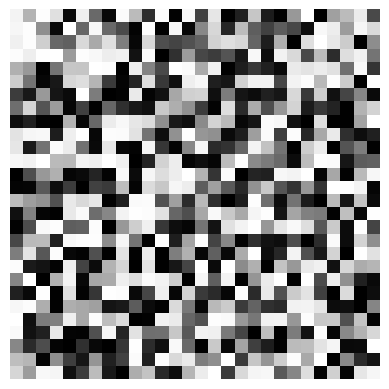

In [198]:
import matplotlib.pyplot as plt

# Generate a single image
noise = np.random.normal(0, 1, (1, 100))
gen_input = Tensor(noise, autograd=True)
generated_image = generator.forward(gen_input)

# Reshape and visualize the generated image
image = generated_image.data.reshape(28, 28)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

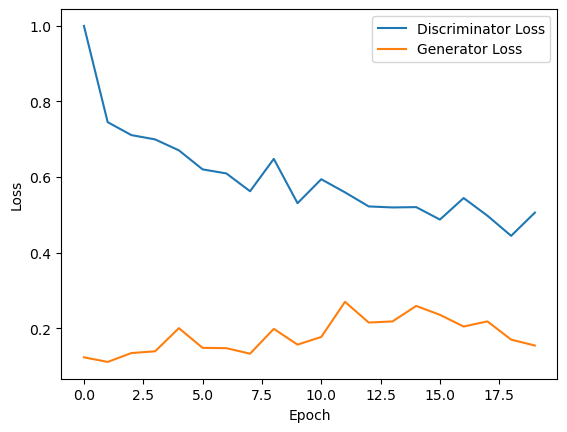

In [180]:
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()